## Imports

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from keras_tuner import HyperParameters
import matplotlib.dates as mdates

# Set Global Random Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Loading and Preprocessing Data

In [3]:
# Load dataset
file_path = 'data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Select Target Variable
target_column = 'DE_load_actual_entsoe_transparency'
target_data = data[[target_column]]  # Keep as DataFrame

# Normalise Target Variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_scaled = scaler.fit_transform(target_data)

print(f"Dataset Shape: {target_data.shape}")

Dataset Shape: (43824, 1)


## Data Splitting

In [4]:
# Split Data into Train (70%), Temp (30%) → Then Split Temp into Validation (15%) & Test (15%)
train_ratio = 0.7
train_data, temp_data = train_test_split(target_data_scaled, train_size=train_ratio, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_data)}")

# Function to Create Sequences for Time-Series Forecasting
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Past `time_steps` values
        y.append(data[i + time_steps])      # Target value at next step
    return np.array(X), np.array(y)

# Define Sequence Length (e.g., last 24 hours → predict next hour)
time_steps = 24

# Create Sequences for Train, Validation, and Test Sets
X_train, y_train = create_sequences(train_data, time_steps)
X_val, y_val = create_sequences(val_data, time_steps)
X_test, y_test_scaled = create_sequences(test_data, time_steps)  # Keep original scaled version

# Store a copy of the scaled test data to ensure we always use the correct scale
y_test_scaled_original = y_test_scaled.copy()

# Reshape Data for LSTM Input (Samples, Time Steps, Features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Train Sequences: {X_train.shape}, Train Labels: {y_train.shape}")
print(f"Validation Sequences: {X_val.shape}, Validation Labels: {y_val.shape}")
print(f"Test Sequences: {X_test.shape}, Test Labels: {y_test_scaled.shape}")


Train Size: 30676, Validation Size: 6574, Test Size: 6574
Train Sequences: (30652, 24, 1), Train Labels: (30652, 1)
Validation Sequences: (6550, 24, 1), Validation Labels: (6550, 1)
Test Sequences: (6550, 24, 1), Test Labels: (6550, 1)


## Evaluation Function

In [6]:
# Function to evaluate models with proper unscaled metrics
def evaluate_model(model, X_test, y_test_scaled, scaler, model_name):
    # Make predictions on scaled data
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)
    
    # Calculate metrics on unscaled values
    test_mape = mape(y_test_actual, y_pred_actual)
    test_mae = mean_absolute_error(y_test_actual, y_pred_actual)
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    test_r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Print evaluation results
    print(f"\n{model_name} - Test Results:")
    print(f"MAPE: {test_mape:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"R² Score: {test_r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual[:100], label="Actual Load", color="blue")
    plt.plot(y_pred_actual[:100], label="Predicted Load", color="orange", linestyle="dashed")
    plt.title(f"{model_name} - Forecast vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return test_mape, test_mae, test_rmse, test_r2

# Initialize results list
results = []

## Simple LSTM Model (10 units)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0700 - val_loss: 0.0047
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011

Test 1: Simple LSTM (10 Units)
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step

Simple LSTM (10 Units) - Test Results:
MAPE: 0.0213
MAE: 1117.9721
RMSE: 1426.9169
R² Score: 0.9782


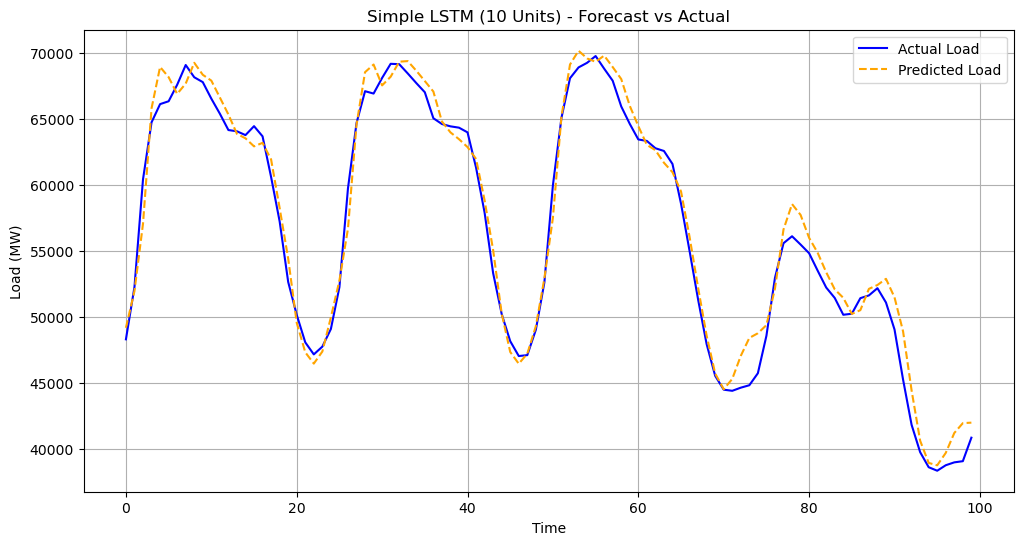

In [7]:
def build_simple_lstm(input_shape):
    model = Sequential([
        LSTM(units=10, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train simple model
input_shape = (X_train.shape[1], X_train.shape[2])
simple_lstm = build_simple_lstm(input_shape)

simple_lstm.fit(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the simple model
print("\nTest 1: Simple LSTM (10 Units)")
simple_lstm_metrics = evaluate_model(
    simple_lstm, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "Simple LSTM (10 Units)"
)
results.append(["Simple LSTM (10 Units)"] + list(simple_lstm_metrics))


## LSTM with 50 Units

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0275 - val_loss: 0.0019
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0011 - val_loss: 8.8942e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.8265e-04 - val_loss: 8.1143e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.1122e-04 - val_loss: 7.7136e-04

Test 2: LSTM (50 Units)
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM (50 Units) - Test Results:
MAPE: 0.0179
MAE: 937.9285
RMSE: 1233.0835
R² Score: 0.9838


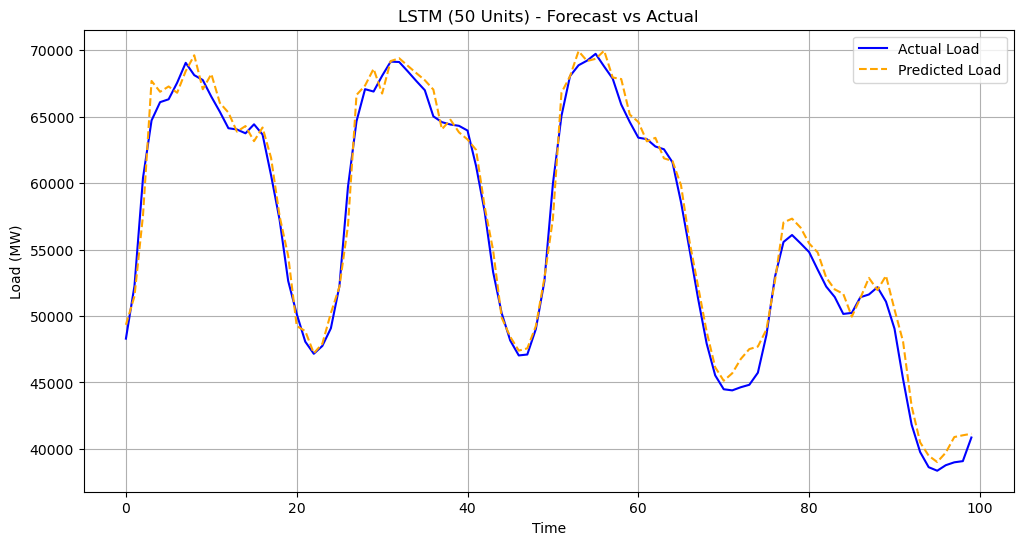

In [6]:
def build_lstm_with_50_units(input_shape):
    model = Sequential([
        LSTM(units=50, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train model with 50 units
lstm_50 = build_lstm_with_50_units(input_shape)

lstm_50.fit(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model with 50 units
print("\nTest 2: LSTM (50 Units)")
lstm_50_metrics = evaluate_model(
    lstm_50, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "LSTM (50 Units)"
)
results.append(["LSTM (50 Units)"] + list(lstm_50_metrics))


## LSTM with 20% Dropout

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0390 - val_loss: 0.0042
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 9.6692e-04

Test 3: LSTM (50 Units + 20% Dropout)
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM (50 Units + 20% Dropout) - Test Results:
MAPE: 0.0207
MAE: 1080.8313
RMSE: 1368.8324
R² Score: 0.9800


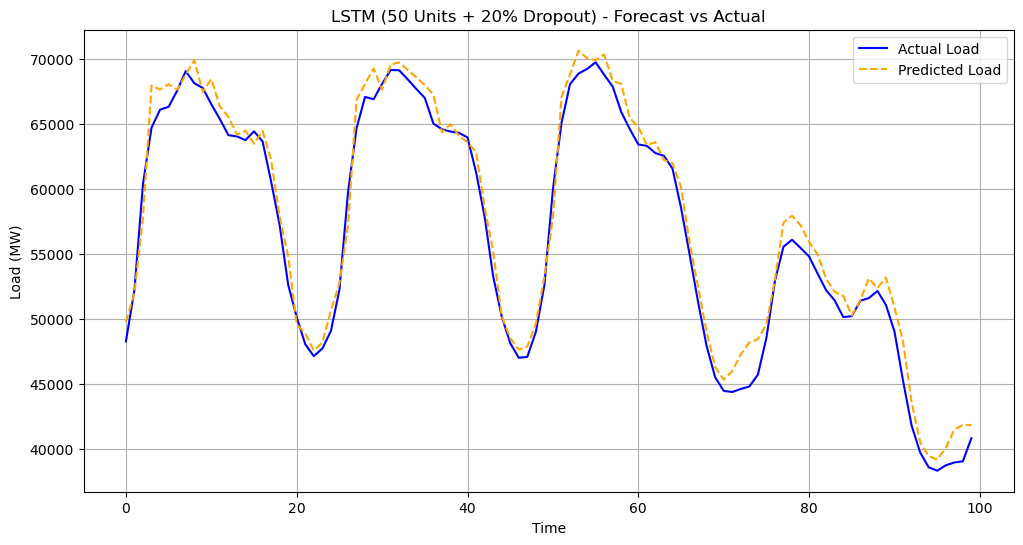

In [7]:
def build_lstm_with_dropout_high(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train model with 20% dropout
lstm_dropout_high = build_lstm_with_dropout_high(input_shape)

lstm_dropout_high.fit(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model with 20% dropout
print("\nTest 3: LSTM (50 Units + 20% Dropout)")
lstm_dropout_high_metrics = evaluate_model(
    lstm_dropout_high, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "LSTM (50 Units + 20% Dropout)"
)
results.append(["LSTM (50 Units + 20% Dropout)"] + list(lstm_dropout_high_metrics))


## LSTM with 10% Dropout

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0305 - val_loss: 0.0028
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 7.8026e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0014 - val_loss: 7.6759e-04

Test 4: LSTM (50 Units + 10% Dropout)
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM (50 Units + 10% Dropout) - Test Results:
MAPE: 0.0167
MAE: 882.3090
RMSE: 1202.0675
R² Score: 0.9846


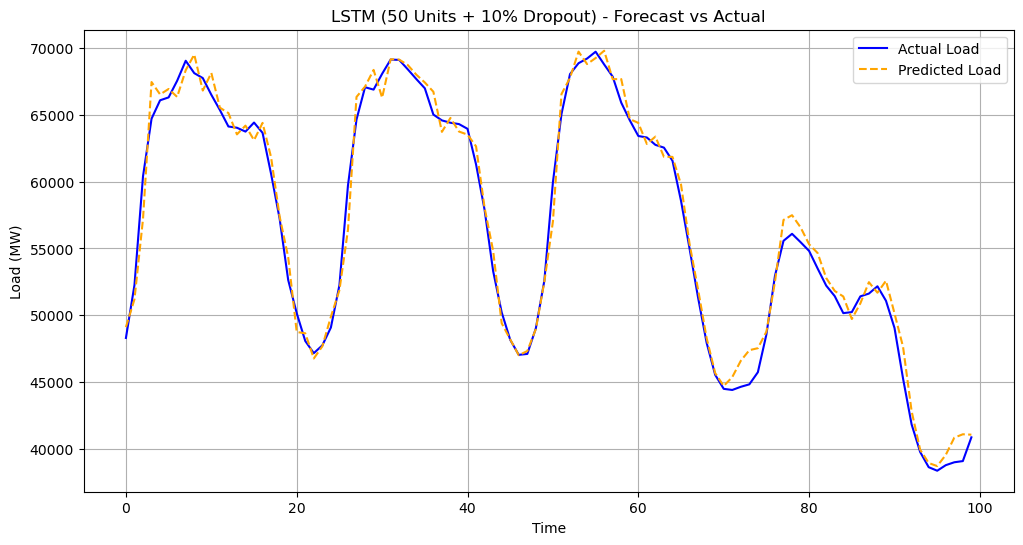

In [8]:
def build_lstm_with_dropout_low(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train model with 10% dropout
lstm_dropout_low = build_lstm_with_dropout_low(input_shape)

lstm_dropout_low.fit(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model with 10% dropout
print("\nTest 4: LSTM (50 Units + 10% Dropout)")
lstm_dropout_low_metrics = evaluate_model(
    lstm_dropout_low, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "LSTM (50 Units + 10% Dropout)"
)
results.append(["LSTM (50 Units + 10% Dropout)"] + list(lstm_dropout_low_metrics))

## Stacked LSTM (50+30 units)

Epoch 1/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0297 - val_loss: 0.0023
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0024 - val_loss: 9.9435e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0018 - val_loss: 7.2675e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0016 - val_loss: 8.3723e-04

Test 5: Stacked LSTM (50+30 Units)
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Stacked LSTM (50+30 Units) - Test Results:
MAPE: 0.0169
MAE: 918.8009
RMSE: 1236.1444
R² Score: 0.9837


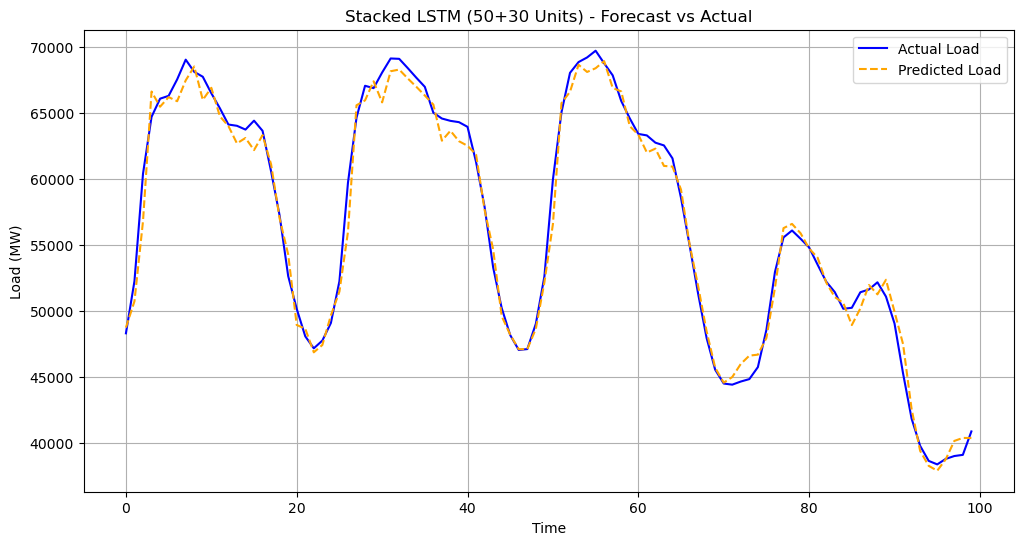

In [10]:
def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.1),
        LSTM(units=30),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train stacked LSTM model
stacked_lstm = build_stacked_lstm(input_shape)

stacked_lstm.fit(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the stacked LSTM model
print("\nTest 5: Stacked LSTM (50+30 Units)")
stacked_lstm_metrics = evaluate_model(
    stacked_lstm, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "Stacked LSTM (50+30 Units)"
)
results.append(["Stacked LSTM (50+30 Units)"] + list(stacked_lstm_metrics))

## Stacked LSTM with Early Stopping (patience=3) and 20 epochs

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0292 - val_loss: 0.0023
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0024 - val_loss: 7.8033e-04
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018 - val_loss: 7.5689e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0015 - val_loss: 7.0022e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0013 - val_loss: 7.5440e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012 - val_loss: 6.8512e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - val_loss: 6.3970e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0010 - val_loss: 6.8740e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9.8982e-04 - val_loss: 6.5266e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.4189e-04 - val_loss: 6.7115e-04
Epoch 11: early st

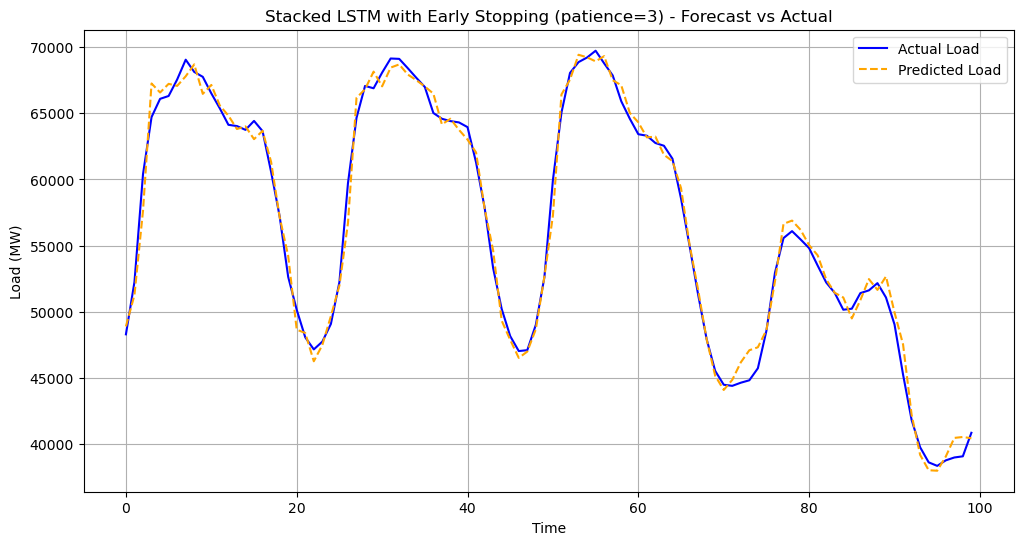

In [11]:
def build_lstm_for_es3(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),  # Added stacked LSTM
        Dropout(0.1),  # Using 10% dropout
        LSTM(units=30),  # Second LSTM layer
        Dropout(0.1),  # Using 10% dropout
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Early stopping callback with patience=3
early_stopping_p3 = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Build and train model with early stopping (patience=3)
lstm_es3 = build_lstm_for_es3(input_shape)

lstm_es3.fit(
    X_train, 
    y_train, 
    epochs=20,  # More epochs since we have early stopping
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_p3],
    verbose=1
)

# Evaluate the model with early stopping (patience=3)
print("\nTest 6: Stacked LSTM with Early Stopping (patience=3)")
lstm_es3_metrics = evaluate_model(
    lstm_es3, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "Stacked LSTM with Early Stopping (patience=3)"
)
results.append(["Stacked LSTM with Early Stopping (patience=3)"] + list(lstm_es3_metrics))


## Stacked LSTM with Early Stopping (patience=5)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0304 - val_loss: 0.0026
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0020 - val_loss: 7.3680e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0016 - val_loss: 7.1624e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014 - val_loss: 7.0201e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0012 - val_loss: 6.5808e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - val_loss: 6.2182e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0010 - val_loss: 6.0748e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9.8402e-04 - val_loss: 6.5862e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.3722e-04 - val_loss: 6.0031e-04
Epoch 12/20
958/958 ━━

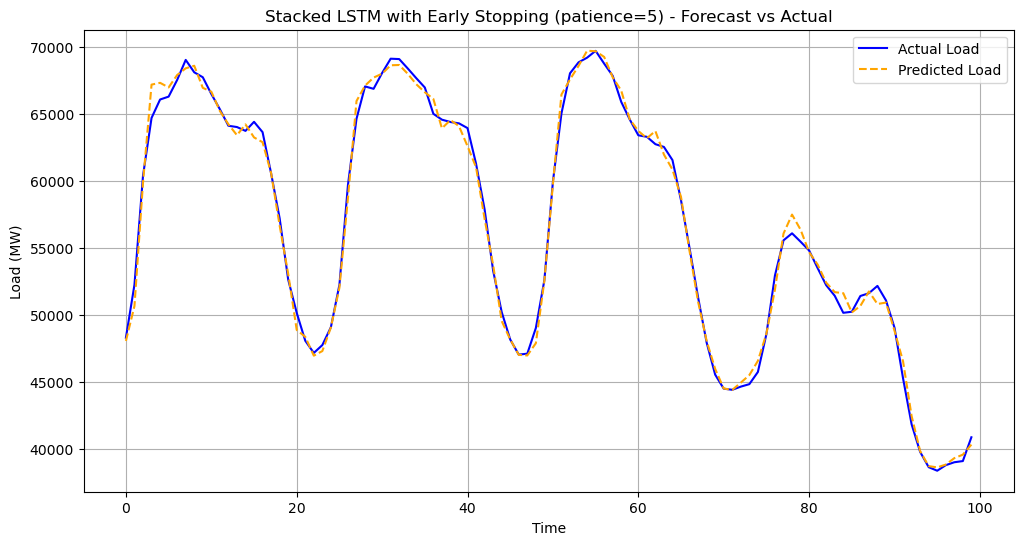

In [12]:
def build_lstm_for_es5(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),  # Added stacked LSTM
        Dropout(0.1),  # Using 10% dropout
        LSTM(units=30),  # Second LSTM layer
        Dropout(0.1),  # Using 10% dropout
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Early stopping callback with patience=5
early_stopping_p5 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Build and train model with early stopping (patience=5)
lstm_es5 = build_lstm_for_es5(input_shape)

lstm_es5.fit(
    X_train, 
    y_train, 
    epochs=20,  # More epochs since we have early stopping
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_p5],
    verbose=1
)

# Evaluate the model with early stopping (patience=5)
print("\nTest 7: Stacked LSTM with Early Stopping (patience=5)")
lstm_es5_metrics = evaluate_model(
    lstm_es5, 
    X_test, 
    y_test_scaled_original, 
    scaler, 
    "Stacked LSTM with Early Stopping (patience=5)"
)
results.append(["Stacked LSTM with Early Stopping (patience=5)"] + list(lstm_es5_metrics))

In [13]:
# Create results DataFrame
results_df = pd.DataFrame(
    results, 
    columns=["Model", "MAPE", "MAE", "RMSE", "R²"]
)

# Print comparison table in original test order
print("\nModel Comparison (in test order):")
print(results_df.to_string(index=False))


Model Comparison (in test order):
                                        Model     MAPE         MAE        RMSE       R²
                       Simple LSTM (10 Units) 0.021272 1117.972124 1426.916891 0.978241
                              LSTM (50 Units) 0.017871  937.928550 1233.083451 0.983751
                LSTM (50 Units + 20% Dropout) 0.020690 1080.831298 1368.832405 0.979976
                LSTM (50 Units + 10% Dropout) 0.016655  882.309015 1202.067515 0.984558
                   Stacked LSTM (50+30 Units) 0.016910  918.800900 1236.144444 0.983670
Stacked LSTM with Early Stopping (patience=3) 0.015220  805.584209 1089.309527 0.987319
Stacked LSTM with Early Stopping (patience=5) 0.010749  573.357241  759.405092 0.993837


Trial 50 Complete [00h 00m 46s]
val_loss: 0.0005820121732540429

Best val_loss So Far: 0.00024646305246278644
Total elapsed time: 02h 49m 35s

Best hyperparameters:
- Stacked LSTM: False
- First LSTM Units: 128
- First Dropout Rate: 0.2
- Learning Rate: 0.01

Top 3 models:

Model #1:
- Val Loss: 0.000246
- stacked: False
- lstm_units_1: 128
- dropout_rate_1: 0.2
- learning_rate: 0.01
- lstm_units_2: 32
- dropout_rate_2: 0.1

Model #2:
- Val Loss: 0.000254
- stacked: True
- lstm_units_1: 32
- dropout_rate_1: 0.0
- learning_rate: 0.01
- lstm_units_2: 128
- dropout_rate_2: 0.1

Model #3:
- Val Loss: 0.000257
- stacked: True
- lstm_units_1: 64
- dropout_rate_1: 0.0
- learning_rate: 0.01
- lstm_units_2: 64
- dropout_rate_2: 0.2

Training the best model...
Epoch 1/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0104 - val_loss: 8.0101e-04
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0012 - val_loss: 6.7131e-04
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step -

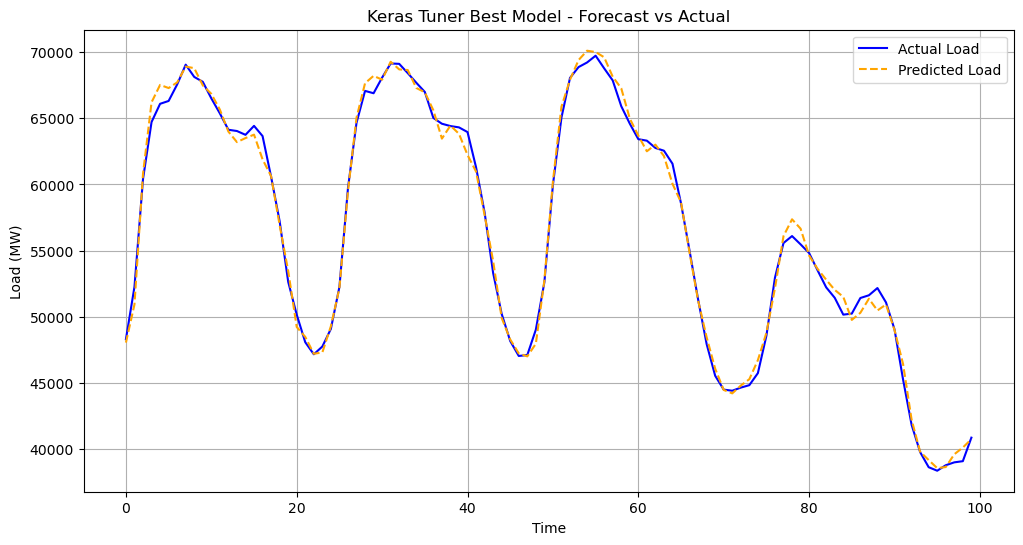


Updated Model Comparison (including tuned model):
                 Model     MAPE        MAE       RMSE       R²
Keras Tuner Best Model 0.010303 546.679507 722.293465 0.994425


In [6]:
# Define the model-building function with hyperparameters
def build_model_for_tuning(hp):
    model = Sequential()
    
    # Tune whether to use stacked LSTM or single layer
    is_stacked = hp.Boolean("stacked")
    
    # Tune number of units in first LSTM layer (powers of 2)
    lstm_units_1 = hp.Choice("lstm_units_1", values=[32, 64, 128, 256])
    
    # First LSTM layer
    if is_stacked:
        model.add(LSTM(units=lstm_units_1, 
                       return_sequences=True, 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(LSTM(units=lstm_units_1, 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # Tune dropout rate after first LSTM
    dropout_rate_1 = hp.Float("dropout_rate_1", min_value=0.0, max_value=0.3, step=0.1)
    if dropout_rate_1 > 0.0:
        model.add(Dropout(dropout_rate_1))
    
    # Add second LSTM layer if stacked
    if is_stacked:
        lstm_units_2 = hp.Choice("lstm_units_2", values=[32, 64, 128])
        model.add(LSTM(units=lstm_units_2))
        
        # Tune dropout rate after second LSTM
        dropout_rate_2 = hp.Float("dropout_rate_2", min_value=0.0, max_value=0.2, step=0.1)
        if dropout_rate_2 > 0.0:
            model.add(Dropout(dropout_rate_2))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.001, 0.01])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mse"
    )
    
    return model

# Create a tuner with RandomSearch to try exactly 50 combinations
tuner = kt.RandomSearch(
    build_model_for_tuning,
    objective="val_loss",
    max_trials=50,  # Exactly 50 combinations
    executions_per_trial=1,
    directory="keras_tuner_dir",
    project_name="lstm_load_forecasting"
)

# Define early stopping callback for tuning
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True
)

# Display search space summary
tuner.search_space_summary()

# Start the search
print("\nStarting hyperparameter search with 50 trials...")
tuner.search(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters and build the best model
print("\nBest hyperparameters:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"- Stacked LSTM: {best_hps.get('stacked')}")
print(f"- First LSTM Units: {best_hps.get('lstm_units_1')}")
print(f"- First Dropout Rate: {best_hps.get('dropout_rate_1')}")

if best_hps.get('stacked'):
    print(f"- Second LSTM Units: {best_hps.get('lstm_units_2')}")
    print(f"- Second Dropout Rate: {best_hps.get('dropout_rate_2')}")

print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# Get the top 3 models
print("\nTop 3 models:")
for i, trial in enumerate(tuner.oracle.get_best_trials(3)):
    print(f"\nModel #{i+1}:")
    print(f"- Val Loss: {trial.score:.6f}")
    params = trial.hyperparameters.values
    for param, value in params.items():
        print(f"- {param}: {value}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
print("\nTraining the best model...")
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the best model
print("\nTest 8: Keras Tuner Best Model")
best_model_metrics = evaluate_model(
    best_model,
    X_test,
    y_test_scaled_original,
    scaler,
    "Keras Tuner Best Model"
)

# Add to results and update the dataframe
results.append(["Keras Tuner Best Model"] + list(best_model_metrics))
results_df = pd.DataFrame(
    results, 
    columns=["Model", "MAPE", "MAE", "RMSE", "R²"]
)

# Print updated comparison table
print("\nUpdated Model Comparison (including tuned model):")
print(results_df.to_string(index=False))

## Best model from Keras Tuner

In [8]:
# Build the best model from hyperparameters
def build_best_model(input_shape):
    model = Sequential([
        LSTM(units=128, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

# Build the model with best hyperparameters
input_shape = (X_train.shape[1], X_train.shape[2])
best_model = build_best_model(input_shape)

# Define early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the best model
print("\nTraining the best model...")
history = best_model.fit(
    X_train, 
    y_train, 
    epochs=20,
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Generate predictions for the full test set
y_pred_scaled = best_model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test_scaled_original.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Evaluate the best model on the full test set
full_mape = mape(y_test_actual, y_pred_actual)
full_mae = mean_absolute_error(y_test_actual, y_pred_actual)
full_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
full_r2 = r2_score(y_test_actual, y_pred_actual)

print(f"\nFull Test Set Metrics:")
print(f"MAPE: {full_mape:.4f}")
print(f"MAE: {full_mae:.4f} MW")
print(f"RMSE: {full_rmse:.4f} MW")
print(f"R²: {full_r2:.4f}")


Training the best model...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0151 - val_loss: 8.8017e-04
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0012 - val_loss: 6.1535e-04
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 9.5137e-04 - val_loss: 5.7903e-04
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 8.2183e-04 - val_loss: 5.0841e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 7.4377e-04 - val_loss: 5.9326e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 6.8948e-04 - val_loss: 3.8885e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 6.2456e-04 - val_loss: 3.8063e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 5.9844e-04 - val_loss: 3.5818e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 5.5850e-04 - val_loss: 4.3744e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 5.0443e-04 - val_loss: 3.7678e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - l

Number of data points in selected period: 120


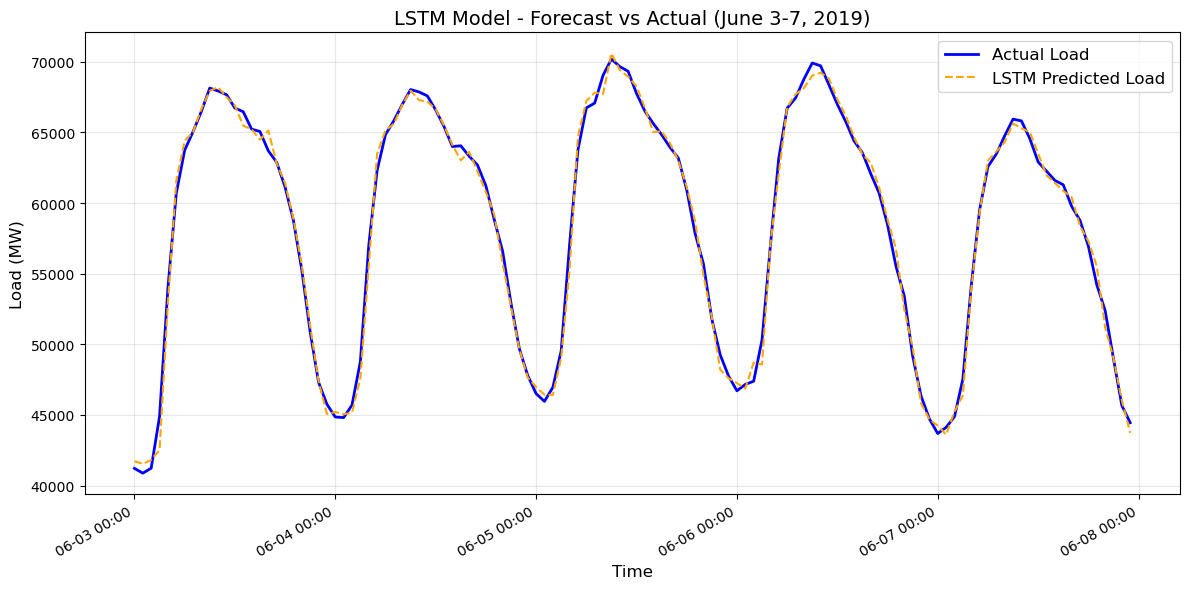


LSTM Model - June 3-7, 2019 Metrics:
MAPE: 0.0094
MAE: 524.0552 MW
RMSE: 671.8445 MW
R²: 0.9938


In [ ]:
# Create DataFrame with predictions for easier date filtering
test_indices = data.index[len(train_data) + len(val_data) + time_steps:len(train_data) + len(val_data) + time_steps + len(y_test_actual)]

predictions_df = pd.DataFrame({
    'actual': y_test_actual.flatten(),
    'predicted': y_pred_actual.flatten()
}, index=test_indices)

# Define date range for June 3-7, 2019
start_date = '2019-06-03'
end_date = '2019-06-07 23:59:59'

# Filter to June 3-7, 2019
filtered_data = predictions_df.loc[start_date:end_date]
print(f"Number of data points in selected period: {len(filtered_data)}")

# Create the standardized visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['actual'], label="Actual Load", color="blue", linewidth=2)
plt.plot(filtered_data.index, filtered_data['predicted'], label="LSTM Predicted Load", color="orange", linestyle="dashed", linewidth=1.5)

# Set title and labels with consistent formatting
plt.title("LSTM Model - Forecast vs Actual (June 3-7, 2019)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Load (MW)", fontsize=12)

# Format x-axis for better date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate metrics for this specific period
period_mape = mape(filtered_data['actual'], filtered_data['predicted'])
period_mae = mean_absolute_error(filtered_data['actual'], filtered_data['predicted'])
period_rmse = np.sqrt(mean_squared_error(filtered_data['actual'], filtered_data['predicted']))
period_r2 = r2_score(filtered_data['actual'], filtered_data['predicted'])

print(f"\nLSTM Model - June 3-7, 2019 Metrics:")
print(f"MAPE: {period_mape:.4f}")
print(f"MAE: {period_mae:.4f} MW")
print(f"RMSE: {period_rmse:.4f} MW")
print(f"R²: {period_r2:.4f}")

Number of data points on June 5th: 24

Hourly Results for LSTM Model - June 5, 2019:
 Hour  Actual Load (MW)  Predicted Load (MW)  Absolute Error (MW)  Percentage Error (%)
    0           46510.0         46983.660156               473.66                  1.02
    1           45963.0         46431.121094               468.12                  1.02
    2           46954.0         46413.480469               540.52                  1.15
    3           49548.0         49039.781250               508.22                  1.03
    4           57040.0         55275.281250              1764.71                  3.09
    5           63757.0         64706.800781               949.80                  1.49
    6           66735.0         67221.140625               486.13                  0.73
    7           67076.0         67815.539062               739.54                  1.10
    8           69040.0         67714.562500              1325.45                  1.92
    9           70194.0         705

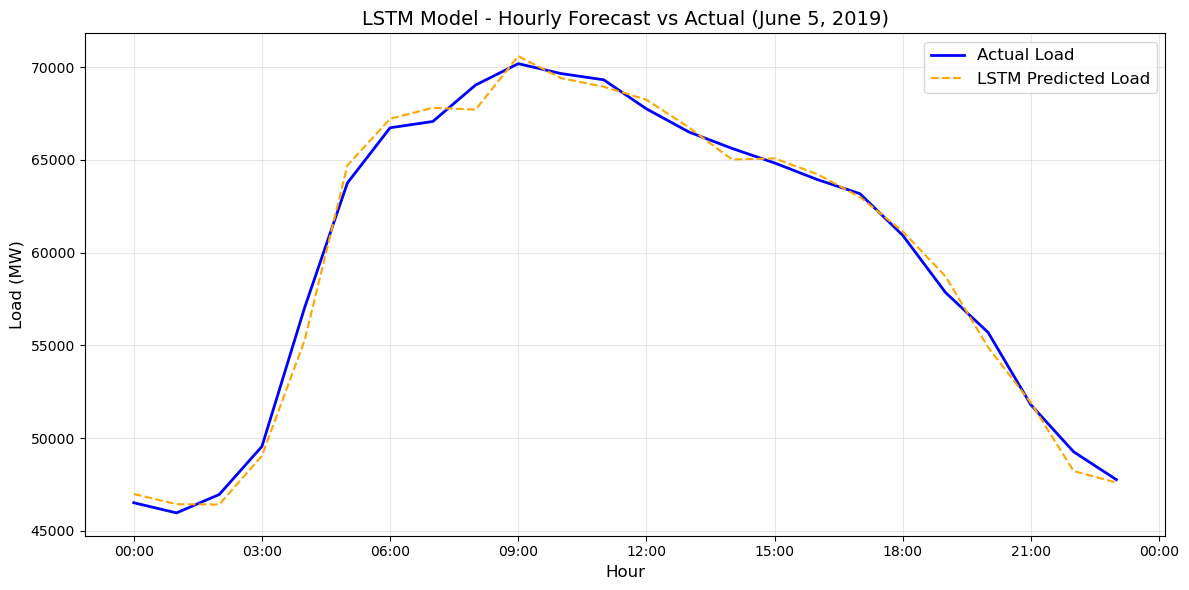

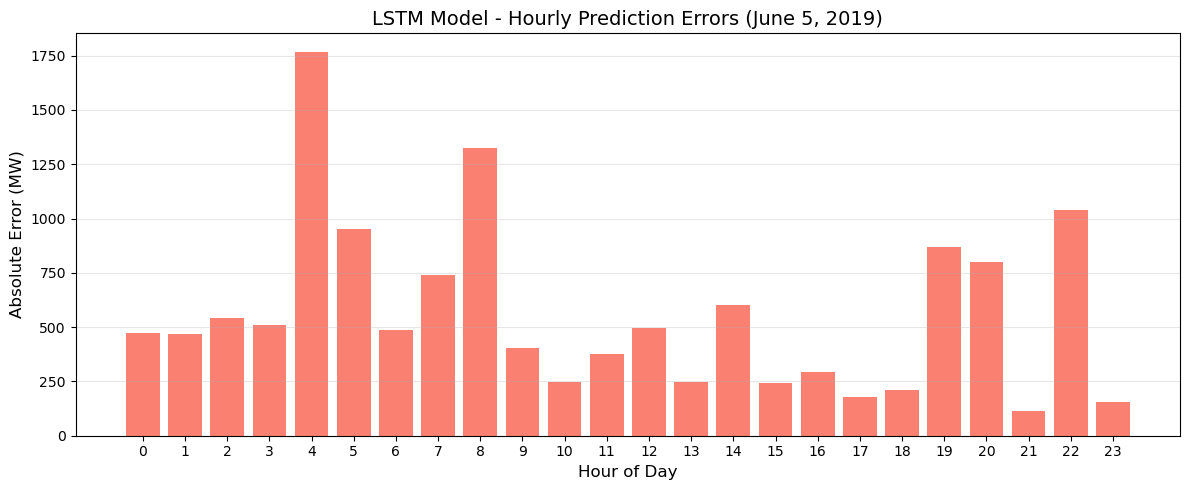

In [13]:
# Detailed hourly analysis for LSTM - June 5th, 2019
specific_date = '2019-06-05'

# Create DataFrame with predictions and timestamps for visualization if not already created
if 'predictions_df' not in locals():
    test_indices = data.index[len(train_data) + len(val_data) + time_steps:len(train_data) + len(val_data) + time_steps + len(y_test_actual)]
    predictions_df = pd.DataFrame({
        'actual': y_test_actual.flatten(),
        'predicted': y_pred_actual.flatten()
    }, index=test_indices)

# Filter to just June 5th data
june_5th_data = predictions_df.loc[specific_date]
print(f"Number of data points on June 5th: {len(june_5th_data)}")

# Create a DataFrame with hourly results
hourly_results = pd.DataFrame({
    'Hour': june_5th_data.index.hour,
    'Actual Load (MW)': june_5th_data['actual'].values,
    'Predicted Load (MW)': june_5th_data['predicted'].values
})

# Calculate hourly errors
hourly_results['Absolute Error (MW)'] = abs(hourly_results['Actual Load (MW)'] - hourly_results['Predicted Load (MW)'])
hourly_results['Percentage Error (%)'] = (hourly_results['Absolute Error (MW)'] / hourly_results['Actual Load (MW)']) * 100

# Format to 2 decimal places for better readability
hourly_results['Actual Load (MW)'] = hourly_results['Actual Load (MW)'].round(2)
hourly_results['Predicted Load (MW)'] = hourly_results['Predicted Load (MW)'].round(2)
hourly_results['Absolute Error (MW)'] = hourly_results['Absolute Error (MW)'].round(2)
hourly_results['Percentage Error (%)'] = hourly_results['Percentage Error (%)'].round(2)

# Display the hourly results as a table
print(f"\nHourly Results for LSTM Model - June 5, 2019:")
print(hourly_results.to_string(index=False))

# Calculate summary statistics
avg_error = hourly_results['Absolute Error (MW)'].mean()
max_error = hourly_results['Absolute Error (MW)'].max()
max_error_hour = hourly_results.loc[hourly_results['Absolute Error (MW)'].idxmax(), 'Hour']
min_error = hourly_results['Absolute Error (MW)'].min()
min_error_hour = hourly_results.loc[hourly_results['Absolute Error (MW)'].idxmin(), 'Hour']

print(f"\nSummary Statistics for June 5, 2019:")
print(f"Average Absolute Error: {avg_error:.2f} MW")
print(f"Maximum Error: {max_error:.2f} MW (Hour {max_error_hour})")
print(f"Minimum Error: {min_error:.2f} MW (Hour {min_error_hour})")

# Create visualization of hourly actual vs. predicted load
plt.figure(figsize=(12, 6))
plt.plot(june_5th_data.index, june_5th_data['actual'], label="Actual Load", color="blue", linewidth=2)
plt.plot(june_5th_data.index, june_5th_data['predicted'], label="LSTM Predicted Load", color="orange", linestyle="dashed")

plt.title("LSTM Model - Hourly Forecast vs Actual (June 5, 2019)", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Load (MW)", fontsize=12)

# Format x-axis to show hours
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=0)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize hourly errors
plt.figure(figsize=(12, 5))
plt.bar(hourly_results['Hour'], hourly_results['Absolute Error (MW)'], color='salmon')
plt.title("LSTM Model - Hourly Prediction Errors (June 5, 2019)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Absolute Error (MW)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()